# Pyro models

In [35]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns

data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


In [36]:
# Arrange the columns so that the years are in order
years = sorted([col for col in data.columns if col.startswith('y_')])
obs = data[years].values  # shape: [N, T]
obs = np.nan_to_num(obs, nan=0).astype(int)  # make sure there are no NaNs

# Encode gender: M=0, F=1
data['gender_code'] = (data['gender'] == 'F').astype(int)

# Normalize birth_year
birth_year_mean = data['birth_year'].mean()
birth_year_std = data['birth_year'].std()
data['birth_year_norm'] = (data['birth_year'] - birth_year_mean) / birth_year_std

years_num = np.array([int(y[2:]) for y in years])  # [2009, ..., 2023]
ages = years_num[None, :] - data['birth_year'].values[:, None]
# Normalize
ages_norm = (ages - ages.mean()) / ages.std()

# Covariates: example with birth_year_norm and gender_code
covariates = data[['birth_year_norm', 'gender_code']].values  # shape: [N, 2]

# Repeat covariates for all years (if fixed per individual)
covariates = np.repeat(covariates[:, None, :], len(years), axis=1)  # shape: [N, T, num_covariates]

# Convert everything to torch tensors
obs_torch = torch.tensor(obs, dtype=torch.long)
covariates_torch = torch.tensor(covariates, dtype=torch.float)

# Add normalized age as a covariate
covariates = np.concatenate([covariates, ages_norm[:, :, None]], axis=2)  # shape: [N, T, 3]
covariates_torch = torch.tensor(covariates, dtype=torch.float)

In [37]:
print(torch.min(obs_torch), torch.max(obs_torch))
num_obs = int(obs_torch.max().item()) + 1
assert obs_torch.min() >= 0 and obs_torch.max() < num_obs
print("Number of observations:", num_obs)


tensor(0) tensor(5)
Number of observations: 6


## HMM without covariates

In [38]:
from pyro.infer import SVI, TraceEnum_ELBO  

num_states = 3  # Number of hidden states
num_obs = int(obs_torch.max().item()) + 1

pyro.clear_param_store()  # resetta tutti i parametri!


def model(observations):
    N, T = observations.shape
    num_states = 3

    emission_probs = pyro.param(
        "emission_probs", torch.ones(num_states, num_obs) / num_obs,
        constraint=dist.constraints.simplex)
    trans_probs = pyro.param(
        "trans_probs", torch.ones(num_states, num_states) / num_states,
        constraint=dist.constraints.simplex)
    init_probs = pyro.param(
        "init_probs", torch.ones(num_states) / num_states,
        constraint=dist.constraints.simplex)

    with pyro.plate("individuals", N):
        state = pyro.sample("state_0", dist.Categorical(init_probs))
        for t in range(T):
            pyro.sample(
                f"obs_{t}",
                dist.Categorical(probs=emission_probs[state]),
                obs=observations[:, t]
            )
            if t < T - 1:
                state = pyro.sample(
                    f"state_{t+1}",
                    dist.Categorical(trans_probs[state])
                )

def guide(observations): pass

optimizer = Adam({"lr": 0.05})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO())

for step in range(2000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Loss at step {step}: {loss}")

# Dopo l'allenamento:
emission_probs = pyro.param("emission_probs").detach().cpu().numpy()
trans_probs = pyro.param("trans_probs").detach().cpu().numpy()
init_probs = pyro.param("init_probs").detach().cpu().numpy()
print("Emission probabilities:\n", emission_probs)
print("Transition probabilities:\n", trans_probs)
print("Initial probabilities:\n", init_probs)

Loss at step 0: 400431.4375


c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_9', 'state_5', 'state_12', 'state_2', 'state_0', 'state_8', 'state_11', 'state_10', 'state_14', 'state_3', 'state_4', 'state_6', 'state_7', 'state_13', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Loss at step 200: 301511.28125
Loss at step 400: 255261.28125
Loss at step 600: 258977.015625
Loss at step 800: 260479.65625
Loss at step 1000: 254501.046875
Loss at step 1200: 237411.953125
Loss at step 1400: 254728.765625
Loss at step 1600: 235379.375
Loss at step 1800: 219442.765625
Emission probabilities:
 [[5.5875540e-01 2.0057279e-01 1.5068510e-01 7.2942980e-02 1.6975543e-02
  6.8148314e-05]
 [5.9998983e-01 1.7862082e-01 1.3574381e-01 6.9113374e-02 1.6403262e-02
  1.2893505e-04]
 [6.9325769e-01 1.2609529e-01 1.0672218e-01 5.9095815e-02 1.4432231e-02
  3.9666973e-04]]
Transition probabilities:
 [[0.755773   0.2412657  0.00296131]
 [0.75706387 0.22536382 0.01757236]
 [0.00729555 0.97483724 0.01786724]]
Initial probabilities:
 [0.03262165 0.8267688  0.14060953]


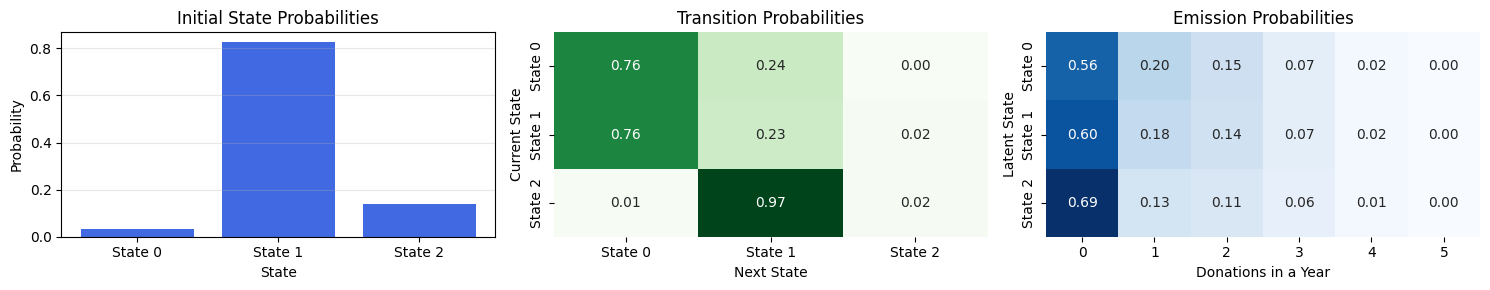

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_hmm_params(transitions, initial_probs, emissions,
                    state_names=None, emission_names=None):
    """
    Plotta in una riga:
    - Matrice di transizione [S, S]
    - Prob iniziali [S]
    - Matrice emissioni [S, K]
    """
    S = len(initial_probs)
    K = emissions.shape[1]
    if state_names is None:
        state_names = [f"State {i}" for i in range(S)]
    if emission_names is None:
        emission_names = [str(i) for i in range(K)]

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Initial probabilities
    axs[0].bar(np.arange(S), initial_probs, color='royalblue')
    axs[0].set_title('Initial State Probabilities')
    axs[0].set_xlabel('State')
    axs[0].set_ylabel('Probability')
    axs[0].set_xticks(np.arange(S))
    axs[0].set_xticklabels(state_names)
    axs[0].grid(axis='y', alpha=0.3)

    # Transition matrix
    sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Greens',
                xticklabels=state_names, yticklabels=state_names, ax=axs[1], cbar=False)
    axs[1].set_title('Transition Probabilities')
    axs[1].set_xlabel('Next State')
    axs[1].set_ylabel('Current State')

    # Emission probabilities/matrix
    sns.heatmap(emissions, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=emission_names, yticklabels=state_names, ax=axs[2], cbar=False)
    axs[2].set_title('Emission Probabilities')
    axs[2].set_xlabel('Donations in a Year')
    axs[2].set_ylabel('Latent State')

    plt.tight_layout()
    plt.show()

# Plot the learned parameters
plot_hmm_params(
    transitions=trans_probs,
    initial_probs=init_probs,
    emissions=emission_probs)

## Full Pyro

### Poisson

In [ ]:
def model(observations):
    N, T = observations.shape
    num_states = 3

    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    rates = pyro.sample("rates", dist.Gamma(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))

    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"ND_{t}", dist.Poisson(rates[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    rates_alpha = pyro.param("rates_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    rates_beta = pyro.param("rates_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))
    pyro.sample("rates", dist.Gamma(rates_alpha, rates_beta).to_event(1))

optimizer = Adam({"lr": .01})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)


for step in range(400):
    loss = svi.step(obs_torch)
    if step % 20 == 0:
        print(f"Step {step} loss: {loss}")

Step 0 loss: 134230.515625
Step 20 loss: 131409.109375
Step 40 loss: 130301.390625
Step 60 loss: 131111.484375
Step 80 loss: 135029.53125
Step 100 loss: 137802.171875
Step 120 loss: 131731.796875
Step 140 loss: 133370.703125
Step 160 loss: 130884.7421875
Step 180 loss: 132648.953125
Step 200 loss: 130461.296875


In [41]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.11651849 0.04377529 0.8397062 ]
Transition matrix (normalized): [[0.21349376 0.00300738 0.00192711]
 [0.00391457 0.2389964  0.00304339]
 [0.02224124 0.04182628 0.4715499 ]]
Poisson rates: [1.942513  1.1133847 0.0219822]


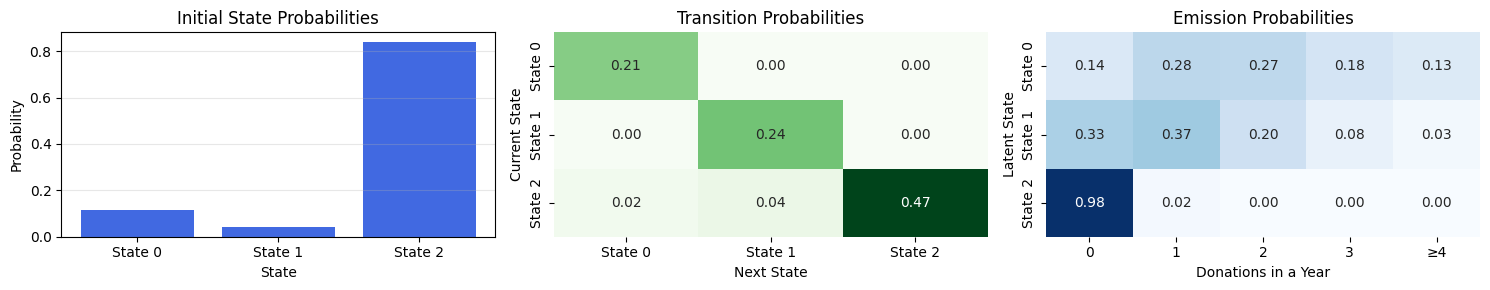

In [42]:
def build_emission_matrix_truncated_poisson(rates, max_k=4):
    S = len(rates)
    K = max_k + 1   # da 0 a max_k incluso
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = poisson.pmf(k, rates[s])
        # L'ultimo raccoglie la coda (tutto >= max_k)
        emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_poisson(rates_norm, max_k=4)

plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Testing

In [ ]:
# Dati finti, gli do una prior per fare testing
pi_true = torch.tensor([0.7, 0.2, 0.1])
A_true = torch.tensor([[0.8,0.1,0.1],[0.2,0.7,0.1],[0.3,0.3,0.4]])
rates_true = torch.tensor([1.0, 5.0, 10.0])
T = 2019 - 2009 + 1  # 2010 to 2019 inclusive
states = [torch.multinomial(pi_true, 1).item()]
obs = []
for t in range(T):
    s = states[-1]
    obs.append(torch.poisson(rates_true[s]))
    states.append(torch.multinomial(A_true[s], 1).item())
obs = torch.stack(obs).unsqueeze(0)  # shape [1,T]

def model(observations):
    N, T = observations.shape
    num_states = 3
    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    rates = pyro.sample("rates", dist.Gamma(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))
    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"ND_{t}", dist.Poisson(rates[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    rates_alpha = pyro.param("rates_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    rates_beta = pyro.param("rates_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))  
    pyro.sample("rates", dist.Gamma(rates_alpha, rates_beta).to_event(1))

optimizer = Adam({"lr": 0.01})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)

for step in range(2000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Step {step}, loss: {loss}")

Step 0, loss: 147822.796875


In [44]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.1463148  0.00658252 0.8471027 ]
Transition matrix (normalized): [[0.2277089  0.00741335 0.00041058]
 [0.0008588  0.36494127 0.00297068]
 [0.01263064 0.03928338 0.34378234]]
Poisson rates: [2.1145298  0.9046744  0.00296376]


Normalize the values

In [45]:
pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", learned_rates_alpha / learned_rates_beta)

Initial state probabilities (normalized): [0.1463148  0.00658252 0.8471027 ]
Transition matrix (normalized): [[0.2277089  0.00741335 0.00041058]
 [0.0008588  0.36494127 0.00297068]
 [0.01263064 0.03928338 0.34378234]]
Poisson rates: [2.1145298  0.9046744  0.00296376]


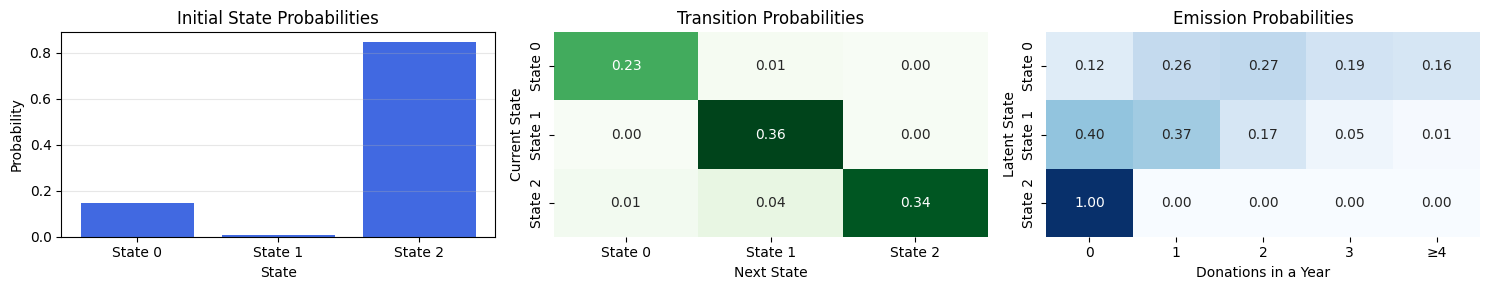

In [48]:
plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=build_emission_matrix_truncated_poisson(rates_norm, max_k=4),
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Geometric

In [49]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam

def model(observations):
    N, T = observations.shape
    num_states = 3

    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    probs = pyro.sample("probs", dist.Beta(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))

    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"y_{t}", dist.Geometric(probs[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    probs_alpha = pyro.param("probs_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    probs_beta = pyro.param("probs_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))
    pyro.sample("probs", dist.Beta(probs_alpha, probs_beta).to_event(1))


optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))

# pyro.render_model(model, model_args=(obs_torch,), render_distributions=False)


for step in range(2000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Step {step} loss: {loss}")

Step 0 loss: 161741.9375
Step 200 loss: 157568.765625
Step 400 loss: 171905.875
Step 600 loss: 166158.578125
Step 800 loss: 149250.140625
Step 1000 loss: 148128.109375
Step 1200 loss: 149511.34375
Step 1400 loss: 147616.765625
Step 1600 loss: 153717.28125
Step 1800 loss: 147354.4375


In [50]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.09040392 0.09322467 0.8163714 ]
Transition matrix (normalized): [[3.4918252e-01 6.9784699e-04 1.6949158e-04]
 [2.5901190e-04 4.4360355e-01 3.7032360e-04]
 [1.1507314e-02 1.5077798e-02 1.7913215e-01]]
Poisson rates: [2.1145298  0.9046744  0.00296376]


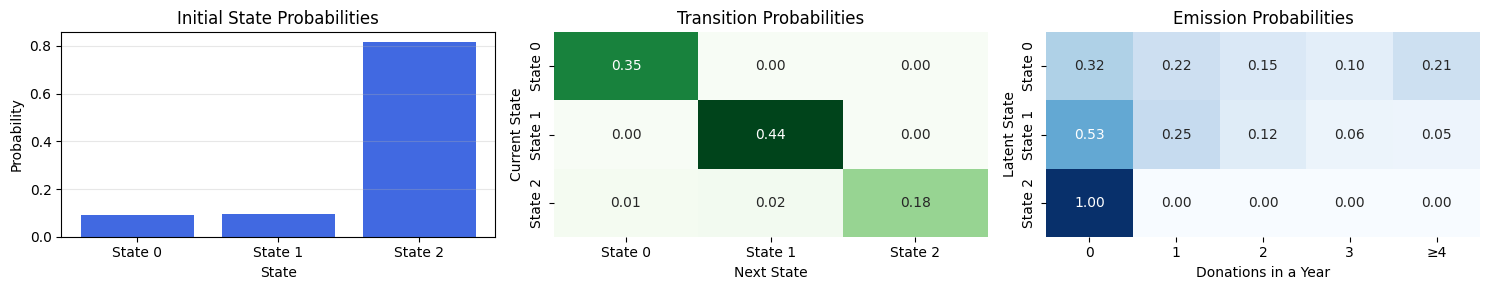

In [51]:
import numpy as np
from scipy.stats import geom

def build_emission_matrix_truncated_geometric(rates, max_k=4):
    S = len(rates)
    K = max_k + 1  # da 0 a 4, 5 valori
    ps = 1 / (rates + 1)
    emissions = np.zeros((S, K))
    for s in range(S):
        # Geometric shiftata: geom.pmf(k+1, p)
        for k in range(max_k):
            emissions[s, k] = geom.pmf(k+1, ps[s])
        # L'ultimo raccoglie tutta la coda: P(y >= max_k)
        emissions[s, max_k] = 1 - geom.cdf(max_k, ps[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_geometric(rates_norm, max_k=4)

plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

## HMM with covariates